In [53]:

from dotenv import load_dotenv
import os
import sys
import json
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt

load_dotenv()

path = os.path.abspath('')
module_path = os.path.join(path,'..\..')
print(module_path)
if module_path not in sys.path:
    sys.path.append(module_path+"\\functions")


from dataset_utils import DatasetEvaluator

c:\Users\rogerrsn\Documents\Tecgraf\Danke-General\gpt-llm-to-keywords\experiments\Analises - Text-to-SQL\..\..


In [3]:

def get_dataset_info(filename):
    dataset = []
    dataset_eval = get_dataset_evaluator(filename)
    queries = read_queries(filename)
    for q in queries:
        expected_sql = dataset_eval.dataset[dataset_eval.id_to_index_map[q["id"]]]["query"]
        column_matching_index = q.get("column_matching_index", 0.0)
        d = {"id":q["id"], "question":q["question"], "type":q["type"], "result":q["result"],
                "generated_sql":q["query_string"], "expected_sql":expected_sql, "similarity":q["similarity"],
                "column_matching_index":column_matching_index}
        dataset.append(d)
    return dataset
            
def get_dataset_evaluator(filename):
    SCHEMA = get_schema(filename)  
    PREFIX = SCHEMA  
    if SCHEMA == "mondial_gpt":
        PREFIX = "mondial"

    dataset_eval = DatasetEvaluator(dataset_file_path=f"../../datasets/{PREFIX}/{PREFIX}_dataset.json",
                                dataset_tables_path=f"../../datasets/{PREFIX}/result_tables/",
                                db_connection_file=f"../../datasets/{SCHEMA}_db_connection.json",
                                dataset_name=SCHEMA)
    return dataset_eval

def read_queries(filename):
    with open(f"../{filename}", encoding="utf-8", errors="ignore") as json_data:
        data = json.load(json_data, strict=False)
    queries = data["queries"]
    
    return queries

def get_experiment_name(filename):
    EXPERIMENT = filename.split("/")[0].upper()
    schema = get_schema(filename).upper()
    
    experiment_name = f"{EXPERIMENT} - {schema}"
    if "chatgpt4" in filename:
        experiment_name += " - GPT-4"
    elif "chatgpt_" in filename:
        experiment_name += " - GPT-3.5"

    if "instances" in filename:
        experiment_name += " - Passing some instances"

    return experiment_name

def get_schema(filename):
    if "mondial_gpt" in filename:
        return "mondial_gpt"
    elif "mondial" in filename:
        return "mondial"
    return ""


# Function to apply styles to cells
def set_color(val):
    color = 'red' if val != True else 'green'
    return f'color: {color}'

def set_value_analysis(row):
    if row['result'] != True:
        return 'Error'
    return ""
     
def generate_dataframe(data, experiment_name, fk_folder="text-to-sql"):
    
    df = pd.DataFrame(data)
    df["analysis"] = df.apply(set_value_analysis, axis=1)
    # Apply styles to the DataFrame
    styled_df = df.style.applymap(set_color, subset=['result'])
    # Export the styled DataFrame to Excel
    styled_df.to_excel(f"results/{fk_folder}/{experiment_name}.xlsx", engine='openpyxl', index=False)

In [3]:
experiment_results_fk = [  
    'C3/results/6_c3_queries_chatgpt4_mondial_gpt_fk.json',
    'DIN/results/6_din_queries_chatgpt4_mondial_gpt_fk.json',
    'DIN-C3/results/6_combining_din_c3_queries_chatgpt4_mondial_gpt_fk.json',
    'SQLQueryChain/results/12_sql_queries_chatgpt4_mondial_gpt_fk.json'
]

In [4]:
i = 1
for file in experiment_results_fk:
    experiment_name = f"{i} - {get_experiment_name(file)}"
    data = get_dataset_info(file)
    generate_dataframe(data, experiment_name, fk_folder="text-to-sql-fk")
    print(experiment_name)
    i+=1

1 - C3 - MONDIAL_GPT - GPT-4
2 - DIN - MONDIAL_GPT - GPT-4
3 - DIN-C3 - MONDIAL_GPT - GPT-4
4 - SQLQUERYCHAIN - MONDIAL_GPT - GPT-4


## Análises dos erros do experimento de melhor performance

In [38]:
gold_experiment_file = "Analise 1 - C3 - MONDIAL_GPT - GPT-4.xlsx"

In [39]:
gold_df = pd.read_excel(f"results/{gold_experiment_file}", engine='openpyxl')
gold_df_false = gold_df[gold_df['result'] == False]
print(len(gold_df_false))
gold_df_false


22


,id,question,type,result,generated_sql,expected_sql,similarity,column_matching_index,analysis,error_analysis
5,6,What is the percentage of religious people are...,complex,False,SELECT percentage FROM religion WHERE name = '...,SELECT r.percentage FROM mondial_religion r IN...,0.0,0.0,Error,"{""schema linking"":[""wrong columns""], ""join"":[""..."
7,8,Find all countries that became independent bet...,complex,False,SELECT code FROM politics WHERE independence B...,SELECT c.name FROM mondial_country c \nINNER J...,-1.0,-1.0,Error,"{""schema linking"":[""wrong columns""], ""join"":[""..."
8,9,What are the cities of Cuba?,medium,False,SELECT name FROM city WHERE country = 'Cuba';,SELECT * FROM mondial_city ci INNER JOIN mondi...,0.0,0.0,Error,"{""schema linking"":[""wrong columns""], ""join"":[""..."
14,15,Tell me the economy of the Caribbean Sea.,medium,False,"SELECT economy.gdp, economy.agriculture, econo...",SELECT DISTINCT e.* FROM mondial_economy e \nI...,0.0,0.0,Error,"{""miscellaneous"":[""distinct""]}"
22,23,How many countries are adjacent to (or ecompas...,medium,False,SELECT COUNT(DISTINCT country) FROM borders WH...,SELECT COUNT(DISTINCT ec.country) AS number_of...,-1.0,-1.0,Error,"{""schema linking"":[""wrong columns"", ""wrong tab..."
23,24,How much area do the countries that are adjace...,complex,False,SELECT SUM(area) FROM country WHERE code IN (S...,SELECT SUM(DISTINCT c.area) AS total_area\nFRO...,0.0,0.0,Error,"{""schema linking"":[""wrong columns"", ""wrong tab..."
24,25,"For all countries, give the sum of the populat...",medium,False,"SELECT country.name, SUM(countrypops.populatio...","SELECT c.name AS country_name, SUM(c1.populati...",1.0,0.5,Error,"{""schema linking"":[""wrong tables""],""join"":[""wr..."
27,28,The codes of all countries for which at least ...,complex,False,SELECT DISTINCT country.code FROM country JOIN...,SELECT DISTINCT s.country\nFROM mondial_geo_es...,-1.0,-1.0,Error,"{""schema linking"":[""wrong columns""]}"
28,29,The codes of all countries where at least one ...,complex,False,SELECT code FROM country WHERE NOT EXISTS ( SE...,SELECT code FROM mondial_country\nWHERE code N...,-1.0,-1.0,Error,"{""nested"":[""set operation""], ""invalid sql"":[""c..."
31,32,What is the area and country of the Chatanga R...,simple,False,"SELECT area, country FROM geo_river JOIN river...","SELECT c.name, r.area FROM mondial_geo_river g...",0.0,0.0,Error,"{""schema linking"":[""wrong columns"", ""wrong ent..."


#### Manipulando os dados do dataframe

In [46]:
categories = gold_df_false['error_analysis'].values
# Converter cada string para JSON
dados_json = [json.loads(item) for item in categories]
dados_json

[{'schema linking': ['wrong columns'], 'join': ['not detected']},
 {'schema linking': ['wrong columns'], 'join': ['not detected']},
 {'schema linking': ['wrong columns'], 'join': ['not detected']},
 {'miscellaneous': ['distinct']},
 {'schema linking': ['wrong columns', 'wrong tables'],
  'join': ['not detected']},
 {'schema linking': ['wrong columns', 'wrong tables'],
  'miscellaneous': ['distinct']},
 {'schema linking': ['wrong tables'],
  'join': ['wrong tables', 'wrong columns']},
 {'schema linking': ['wrong columns']},
 {'nested': ['set operation'], 'invalid sql': ['condition']},
 {'schema linking': ['wrong columns', 'wrong entities']},
 {'schema linking': ['wrong columns']},
 {'join': ['wrong tables', 'wrong columns']},
 {'schema linking': ['wrong columns']},
 {'join': ['wrong columns']},
 {'schema linking': ['wrong tables', 'wrong columns'],
  'join': ['wrong tables', 'wrong columns']},
 {'schema linking': ['wrong columns']},
 {'schema linking': ['wrong columns']},
 {'schema link

### Frequencias das categorias de erros

In [51]:
# Obter todas as chaves
categories_keys = [chave for item in dados_json for chave in item]
# Calcular a frequência das chaves
frequency_categories = Counter(categories_keys)
frequency_categories

Counter({'schema linking': 16,
         'join': 9,
         'miscellaneous': 2,
         'invalid sql': 2,
         'nested': 1})

### Gráfico das categorias de erros

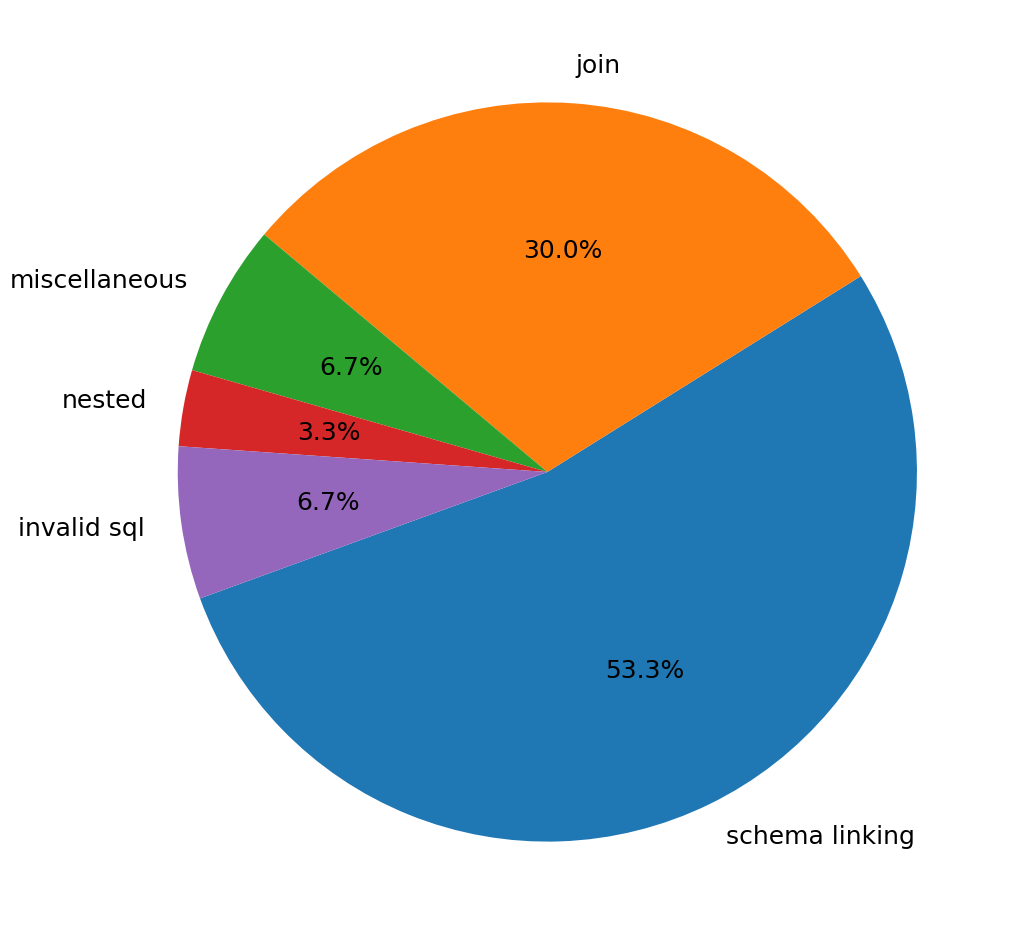

In [63]:

# Plotar um gráfico de barras para as chaves
plt.figure(figsize=(12, 12))
plt.pie(frequency_categories.values(), labels=frequency_categories.keys(), autopct='%1.1f%%',  startangle=200, textprops={'fontsize': 18})
plt.savefig('error_analysis_chart.png')
plt.show()


## Testes

In [35]:
file = experiment_results[0]
file

'SQLQueryChain/results/1_sql_queries_chatgpt_mondial.json'

In [36]:
data = get_dataset_info(file)
data

[{'id': '1',
  'question': 'What is the area of Thailand?',
  'type': 'simple',
  'result': True,
  'generated_sql': "SELECT area FROM mondial_country WHERE name = 'Thailand'",
  'expected_sql': "SELECT max(area) FROM mondial_country where name  = 'Thailand'",
  'similarity': 1.0,
  'column_matching_index': 1.0},
 {'id': '2',
  'question': 'What are the provinces with an area greater than 10000?',
  'type': 'simple',
  'result': True,
  'generated_sql': 'SELECT name\nFROM mondial_province\nWHERE area > 10000',
  'expected_sql': 'SELECT name FROM mondial_province where area > 10000',
  'similarity': 1.0,
  'column_matching_index': 1.0},
 {'id': '3',
  'question': 'What are the languages spoken in Poland?',
  'type': 'medium',
  'result': False,
  'generated_sql': "SELECT name FROM mondial_language WHERE country = 'POL'",
  'expected_sql': "SELECT mondial_language.name FROM mondial_language INNER JOIN mondial_country ON mondial_language.country = mondial_country.code WHERE mondial_countr

In [37]:
df = pd.DataFrame(data)
df

,id,question,type,result,generated_sql,expected_sql,similarity,column_matching_index
0,1,What is the area of Thailand?,simple,True,SELECT area FROM mondial_country WHERE name = ...,SELECT max(area) FROM mondial_country where na...,1.0,1.000000
1,2,What are the provinces with an area greater th...,simple,True,SELECT name\nFROM mondial_province\nWHERE area...,SELECT name FROM mondial_province where area >...,1.0,1.000000
2,3,What are the languages spoken in Poland?,medium,False,SELECT name FROM mondial_language WHERE countr...,SELECT mondial_language.name FROM mondial_lang...,0.0,0.000000
3,4,How deep is Lake Kariba?,simple,True,SELECT depth FROM mondial_lake WHERE name = 'L...,SELECT depth FROM mondial_lake where name LIKE...,1.0,1.000000
4,5,What is the total of provinces of Netherlands?,complex,False,SELECT COUNT(*) FROM mondial_province WHERE co...,SELECT count(*) FROM mondial_province p INNER ...,0.0,0.000000
...,...,...,...,...,...,...,...,...
95,96,List the countries and the sum of their provin...,simple,True,"SELECT c.name AS country, SUM(p.area) AS total...","SELECT c.name AS country, SUM(p.area) AS total...",1.0,1.000000
96,97,"Show the name of the countries, the average el...",medium,False,"SELECT c.name, AVG(ci.elevation) AS average_el...","SELECT c.name AS country, AVG(ci.elevation) AS...",1.0,0.333333
97,98,What was Germany's inflation?,medium,False,SELECT inflation FROM mondial_economy WHERE co...,SELECT e.inflation FROM mondial_country c JOIN...,0.0,0.000000
98,99,What type of government is Iran?,medium,False,SELECT government\nFROM mondial_politics\nWHER...,SELECT p.government\nFROM mondial_country c\nI...,0.0,0.000000


In [38]:
styled_df = df.style.applymap(set_color, subset=['result'])
styled_df

,id,question,type,result,generated_sql,expected_sql,similarity,column_matching_index
0,1,What is the area of Thailand?,simple,True,SELECT area FROM mondial_country WHERE name = 'Thailand',SELECT max(area) FROM mondial_country where name = 'Thailand',1.000000,1.000000
1,2,What are the provinces with an area greater than 10000?,simple,True,SELECT name FROM mondial_province WHERE area > 10000,SELECT name FROM mondial_province where area > 10000,1.000000,1.000000
2,3,What are the languages spoken in Poland?,medium,False,SELECT name FROM mondial_language WHERE country = 'POL',SELECT mondial_language.name FROM mondial_language INNER JOIN mondial_country ON mondial_language.country = mondial_country.code WHERE mondial_country.name = 'Poland',0.000000,0.000000
3,4,How deep is Lake Kariba?,simple,True,SELECT depth FROM mondial_lake WHERE name = 'Lake Kariba',SELECT depth FROM mondial_lake where name LIKE '%Lake Kariba%',1.000000,1.000000
4,5,What is the total of provinces of Netherlands?,complex,False,SELECT COUNT(*) FROM mondial_province WHERE country = 'NLD',SELECT count(*) FROM mondial_province p INNER JOIN mondial_country c ON p.country = c.code WHERE c.name = 'Netherlands',0.000000,0.000000
5,6,What is the percentage of religious people are hindu in thailand?,complex,True,SELECT percentage FROM mondial_religion WHERE country = 'THA' AND name = 'Hindu',SELECT r.percentage FROM mondial_religion r INNER JOIN mondial_country c ON r.country = c.code WHERE c.name = 'Thailand' AND r.name LIKE '%Hindu%',1.000000,1.000000
6,7,List the number of provinces each river flows through.,medium,False,"SELECT r.river, COUNT(DISTINCT rth.province) AS num_provinces FROM mondial_river r JOIN mondial_riverthrough rth ON r.name = rth.river GROUP BY r.river ORDER BY num_provinces DESC","SELECT r.name, count(gr.province) AS count_province FROM mondial_province p INNER JOIN mondial_geo_river gr ON gr.province = p.name INNER JOIN mondial_river r ON gr.river = r.name GROUP BY r.name",-1.000000,-1.000000
7,8,Find all countries that became independent between 8/1/1910 and 8/1/1950.,complex,False,"SELECT name FROM mondial_politics WHERE independence BETWEEN TO_DATE('8/1/1910', 'MM/DD/YYYY') AND TO_DATE('8/1/1950', 'MM/DD/YYYY')",SELECT c.name FROM mondial_country c INNER JOIN mondial_politics p ON c.code = p.country WHERE independence > DATE '1910-08-01' AND independence < DATE '1950-08-01',-1.000000,-1.000000
8,9,What are the cities of Cuba?,medium,False,SELECT name FROM mondial_city WHERE country = 'CUB',SELECT * FROM mondial_city ci INNER JOIN mondial_country c on ci.country = c.code where c.name = 'Cuba',0.000000,0.000000
9,10,What is the capital of Georgia?,medium,False,SELECT capital FROM mondial_country WHERE name = 'Georgia',SELECT capital FROM mondial_country WHERE name = 'Georgia',0.000000,0.000000
